# NVIDIA NIM & AutoRank - comparing Mistral and Meta LLMs

### Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
import utils

from dotenv import load_dotenv
from datasets import load_dataset
from generator import Generator

load_dotenv('env/var.env')


/Users/rafael/miniconda3/envs/nim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Define models

In [2]:
llama8b = Generator(model='meta/llama3-8b-instruct', ngc_key=os.getenv("NGC_API_KEY"))
mistral7b = Generator(model="mistralai/mistral-7b-instruct-v0.3", ngc_key=os.getenv("NGC_API_KEY"))
llama70b = Generator(model="meta/llama3-70b-instruct", ngc_key=os.getenv("NGC_API_KEY"))
mixtral = Generator(model="mistralai/mixtral-8x22b-instruct-v0.1", ngc_key=os.getenv("NGC_API_KEY"))

### Load Q&A Data 

In [3]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [4]:
llama8b_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

mistral7b_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

llama70b_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

mixtral_metrics = {
    "words_per_second": [],
    "words": [],
    "rank": [],
}

### Gather metrics

In [ ]:
for i in range(100):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # llama 8b
    answer_llama, words_per_second, words = utils.get_llm_response(llama8b, context, query)
    llama8b_metrics["words_per_second"].append(words_per_second)
    llama8b_metrics["words"].append(words)

    # mistral 7b 
    answer_mistral, words_per_second, words = utils.get_llm_response(mistral7b, context, query)
    mistral7b_metrics["words_per_second"].append(words_per_second)
    mistral7b_metrics["words"].append(words)

    # llama 70b
    answer_llama70b, words_per_second, words = utils.get_llm_response(llama70b, context, query)
    llama70b_metrics["words_per_second"].append(words_per_second)
    llama70b_metrics["words"].append(words)

    # mixtral
    answer_mixtral, words_per_second, words = utils.get_llm_response(mixtral, context, query)
    mixtral_metrics["words_per_second"].append(words_per_second)
    mixtral_metrics["words"].append(words)

    # GPT-3.5 rank
    llm_answers_dict = {'llama8b': answer_llama, 'mistral7b': answer_mistral, 'llama70b': answer_llama70b, 'mixtral': answer_mixtral}
    rank = utils.get_gpt_rank(answer, llm_answers_dict, os.getenv("OPENAI_API_KEY"))

    llama8b_metrics["rank"].append(rank.index('1')+1)
    mistral7b_metrics["rank"].append(rank.index('2')+1)
    llama70b_metrics["rank"].append(rank.index('3')+1)
    mixtral_metrics["rank"].append(rank.index('4')+1)
    

### Metrics comparison

#### Mistral 7B vs Llama 2 7B vs Gemma 7B

In [21]:
mistral7b_metrics = pd.DataFrame(mistral7b_metrics)
mistral7b_metrics['model'] = 'Mistral 7B'
llama8b_metrics = pd.DataFrame(llama8b_metrics)
llama8b_metrics['model'] = 'Llama 3 8B'
llama70b_metrics = pd.DataFrame(llama70b_metrics)
llama70b_metrics['model'] = 'Llama 3 70B'
mixtral_metrics = pd.DataFrame(mixtral_metrics)
mixtral_metrics['model'] = 'Mixtral 8x22B'

# create single data frame for plotting
metrics = pd.concat([mistral7b_metrics, llama8b_metrics, llama70b_metrics, mixtral_metrics])

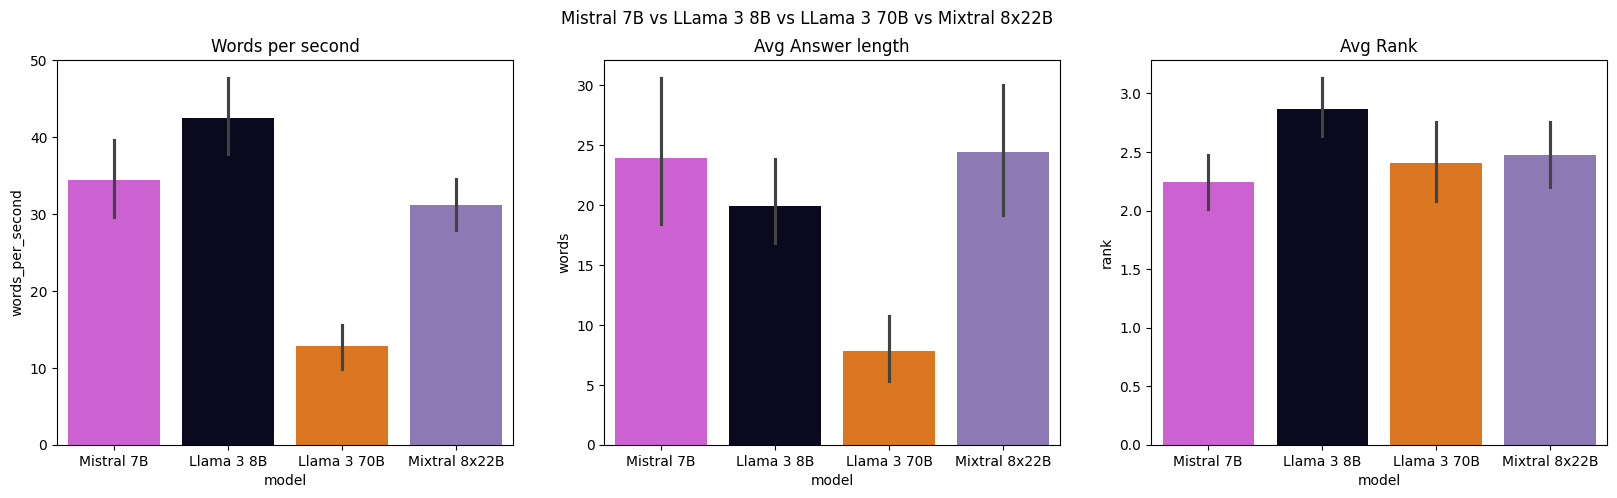

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Mistral 7B vs LLama 3 8B vs LLama 3 70B vs Mixtral 8x22B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302", "#8a70beff"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302",  "#8a70beff"])
axes[1].set_title("Avg Answer length")

sns.barplot(ax=axes[2], data=metrics, y='rank', x='model', hue='model', palette=["#dd4fe4", "#070620", "#fa7302",  "#8a70beff"])
axes[2].set_title("Avg Rank")

plt.show()

## Statiscal Test
- Check if p_values are higher than the level of significance:
    - false means that two groups are statistically different.

In [29]:
p_values = sp.posthoc_dunn([mistral7b_metrics['rank'], llama8b_metrics['rank'], llama70b_metrics['rank'], mixtral_metrics['rank']], p_adjust='holm')
p_values > 0.05

,1,2,3,4
1,True,False,True,True
2,False,True,True,True
3,True,True,True,True
4,True,True,True,True
